In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

/device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [ ]:
!pip install pydicom

In [ ]:
import pydicom as dicom
import json
import cv2
import math
import random
import os
import csv
import h5py
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [ ]:
# Read JSON
data_path = '/content/drive/My Drive/rsna-pneumonia-detection-challenge/'
os.chdir(data_path)
with open ('data.json','r') as read_file:
    JasonData = json.load(read_file)

In [ ]:
# Convert into numpy array
train_data = np.array(list(JasonData.items()))
print(len(train_data))

26684


In [ ]:
y_ = []
for i in range(len(train_data)):
  y_.append(train_data[i][1]['label'])


In [ ]:
count_1 = 0
count_0 = 0
for i in range(len(train_data)):
  if train_data[i][1]['label'] == 1 :
    count_1 += 1
  if train_data[i][1]['label'] == 0 :
    count_0 += 1

ct_0 = round(count_0 * 0.9)
ct_1 = round(count_1 * 0.9)

train_0 = round(ct_0 * 0.7)
train_1 = round(ct_1 * 0.7)
val_0 = round(ct_0 * 0.3)
val_1 = round(ct_1 * 0.3)
test_0 = round(count_0 * 0.1)
test_1 = round(count_1 * 0.1)


X_train = []
X_val = []
X_test = []

for i in range(len(train_data)):
  if train_data[i][1]['label'] == 1 and train_1 != 0:
    X_train.append(train_data[i])
    train_1 -= 1
  elif train_data[i][1]['label'] == 0 and train_0 != 0:
    X_train.append(train_data[i])
    train_0 -= 1
  elif train_data[i][1]['label'] == 1 and val_1 != 0:
    X_val.append(train_data[i])
    val_1 -= 1
  elif train_data[i][1]['label'] == 0 and val_0 != 0:
    X_val.append(train_data[i])
    val_0 -= 1
  elif train_data[i][1]['label'] == 1 and test_1 != 0:
    X_test.append(train_data[i])
    test_1 -= 1
  elif train_data[i][1]['label'] == 0 and test_0 != 0:
    X_test.append(train_data[i])
    test_0 -= 1



In [ ]:
len(X_test),len(X_train), len(X_val)

(2667, 16812, 7205)

In [ ]:
# Image size for model input
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

# original image dimensions
imageWidth=1024
imageHeight=1024

In [ ]:
#defining parameter
EPOCHS = 100
BATCH_SIZE = 16

In [ ]:

class DataGenerator(Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=True, predict=False):        
        self.dataset = dataset
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.predict=predict
        self.on_epoch_end()
    
    def __len__(self):         
        return math.ceil(len(self.dataset)/self.batch_size)    
       
    def __getitem__(self, index):   
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        image_batch = [self.dataset[i][1]['dicom'] for i in indexes]
        bbox_batch = [self.dataset[i][1]['boxes'] for i in indexes]
        
        X = self.__generate_X(image_batch)
        if self.predict:
            return X
        else:
            masks = self.__generate_masks(bbox_batch)
            return X, masks
        
    def __generate_X(self, image_batch): 
        
        X = np.zeros((len(image_batch), IMAGE_WIDTH, IMAGE_HEIGHT,3), dtype=np.float32)
        for k, image_path in enumerate(image_batch):
            img = dicom.read_file(image_path).pixel_array
            img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
            img = np.stack((img,)*3, axis=-1)
            X[k] = preprocess_input(np.array(img, dtype=np.float32))
        return X
                
    def __generate_masks(self, bbox_batch):        
        
        masks = np.zeros((len(bbox_batch), IMAGE_WIDTH, IMAGE_HEIGHT))
        width_factor = IMAGE_WIDTH/imageWidth
        height_factor = IMAGE_HEIGHT/imageHeight
        
        for k, bbox_items in enumerate(bbox_batch):
            if len(bbox_items) > 0:
                for idx, val in enumerate(bbox_items):
                    x1 = round(val[0]* width_factor)
                    x2 = round((val[0]+val[2])* width_factor)
                    y1 = round(val[1]*height_factor)  
                    y2 = round((val[1]+val[3])*height_factor)
                    masks[k][y1:y2, x1:x2]=1                    
            else:
                masks[k][:,:]=0                
        return masks
                   
    def on_epoch_end(self):  
        self.indexes = np.arange(len(self.dataset))      
        if self.shuffle == True:
            np.random.shuffle(self.indexes) 
    
   

In [ ]:
#creating model 
def create_model(trainable=True):
    
    model = DenseNet121(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False,weights='imagenet')
    for layer in model.layers:
      layer.trainable = trainable
        
    block1 = model.get_layer("conv1/relu").output
    block2 = model.get_layer("pool2_relu").output
    block3 = model.get_layer("pool3_relu").output
    block4 = model.get_layer("pool4_relu").output
    block5 = model.get_layer("conv5_block16_0_relu").output
  
    x=Concatenate(axis=3)([UpSampling2D()(block5),block4])
    x=Conv2D(512,kernel_size=(3,3),padding='same',activation='relu')(x)
    x=Concatenate(axis=3)([UpSampling2D()(x),block3])
    x=Conv2D(256,kernel_size=(3,3),padding='same',activation='relu')(x)
    x=Concatenate(axis=3)([UpSampling2D()(x),block2])
    x=Conv2D(128,kernel_size=(3,3),padding='same',activation='relu')(x)
    x=Concatenate(axis=3)([UpSampling2D()(x),block1])
    x=Conv2D(64,kernel_size=(3,3),padding='same',activation='relu')(x)
    x=Concatenate(axis=3)([UpSampling2D()(x),model.input])
    x=Conv2D(32,kernel_size=(3,3),padding='same',activation='relu')(x)
    x=Conv2D(1,kernel_size=(3,3),padding='same',activation='sigmoid')(x)
    x=Reshape((IMAGE_WIDTH,IMAGE_HEIGHT))(x)
    return Model(inputs=model.input, outputs=x)

In [ ]:
# define custome metrics 
with mirrored_strategy.scope():
  # dice coefficient
  def dice_coefficient(y_true, y_pred):
      numerator = 2 * tf.reduce_sum(y_true * y_pred)
      denominator = tf.reduce_sum(y_true + y_pred)
      return numerator / (denominator + tf.keras.backend.epsilon())

In [ ]:
# define loss
with mirrored_strategy.scope():
  def loss(y_true, y_pred):
      return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [ ]:
# define optimizer 
from  tensorflow.keras import optimizers
with mirrored_strategy.scope():
  optimizer = optimizers.Adam(learning_rate = 0.001)

In [ ]:
with mirrored_strategy.scope():
  # define checkpoint,early stop,platequ point
  weights_path = os.path.join(data_path,"model_&_weights/densenet121_unet/","model-{loss:.2f}.h5")
  checkpoint = ModelCheckpoint(weights_path, monitor="loss", verbose=1, save_best_only=True,
                              save_weights_only=True, mode="min", save_freq='epoch')
  stop = EarlyStopping(monitor="loss", patience=5, mode="min")
  reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [ ]:
# shift architecture from CPU to TPU
#with tpu_strategy.scope():
with mirrored_strategy.scope():
  model = create_model(False)
  model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
train_gen = DataGenerator(X_train,batch_size=BATCH_SIZE, shuffle=True, predict=False)
val_gen = DataGenerator(X_val, batch_size=BATCH_SIZE, shuffle=True, predict=False)


In [ ]:
# Train model
result = model.fit_generator(generator=train_gen,validation_data = val_gen,
                    epochs= EPOCHS, callbacks = [checkpoint, reduce_lr, stop],shuffle=True, verbose=1)

Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/ta

In [ ]:
model.save(os.path.join(data_path,'Model/desnet121_v2.h5'))

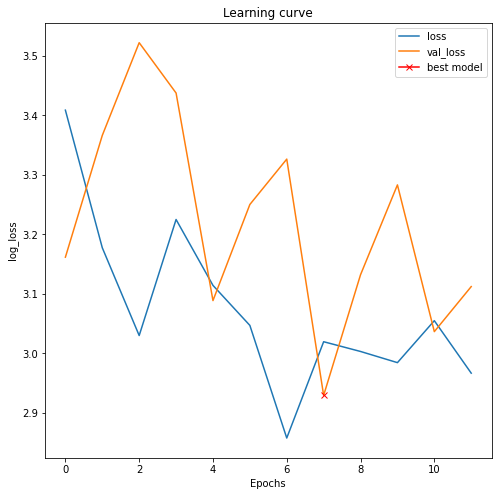

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(result.history["loss"], label="loss")
plt.plot(result.history["val_loss"], label="val_loss")
plt.plot( np.argmin(result.history["val_loss"]), np.min(result.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
model = create_model()
model.load_weights(os.path.join(data_path,"model_&_weights/densenet121_unet/","model-2.86.h5"))
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [ ]:
test_masks = np.zeros((int(len(X_test)), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float32)
test_img = np.zeros((int(len(X_test)), IMAGE_HEIGHT, IMAGE_WIDTH,3), dtype=np.float32)

In [ ]:
for index in tqdm(range(len(X_test))):
    img = dicom.read_file(X_test[index][1]['dicom']).pixel_array
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    img = np.stack((img,)*3, axis=-1)            
    test_img[index]=preprocess_input(np.array(img, dtype=np.float32))
    
    for i in X_test[index][1]['boxes']:
      x1 = round(i[0]*IMAGE_WIDTH/imageWidth)
      x2 = round((i[0]+i[2])*IMAGE_WIDTH/imageWidth)
      y1 = round(i[1]*IMAGE_HEIGHT/imageHeight)         
      y2 = round((i[1]+i[3])*IMAGE_HEIGHT/imageHeight)
      test_masks[index][y1:y2, x1:x2]=1

100%|██████████| 2667/2667 [00:32<00:00, 81.02it/s]


In [ ]:
index_0 = []
index_1 = []
index = []
for i in range(len(X_test)):
  if X_test[i][1]['label'] == 0:
    index_0.append(i)
  else:
    index_1.append(i)
  index.append(X_test[i][1]['label'])

In [ ]:
per_mat = pd.DataFrame(columns=['Minimum_Confidence','True Positive','True Negative','False Positive','False Negative','Accuracy','Recall','Precision','F1-score','Specificity'])

In [ ]:
from skimage.measure import label, regionprops, regionprops_table

In [ ]:
def find_bbox(regions):
  MIN_AREA=100
  boxes = []
  for props in regions:    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    
    if props.area > MIN_AREA:
        x = props.bbox[1]
        y = props.bbox[2]
        w = props.bbox[1]+props.bbox[3]
        h = props.bbox[0]+props.bbox[2]
        boxes.append([x,y,w,h]) 
  return boxes

In [ ]:
def performace_matrix(test_data = X_test,test = test_img,per_mat = per_mat):

  """
  Here wee are not checking whether model has correctly identifying boundry boxes or not,
  we are only checking that whether model is correctly classifying the patient for pneumonia and non pneumonia
  """

  lt = [0.5,.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.92,0.94,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.983,0.985,0.987,0.99]
  for j in range(len(lt)):
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    threshold = lt[j]
    for i in range(len(test_data)):
      pred_mask = model.predict(test_img[i].reshape(1,224,224,3))
      pred_mask = pred_mask.reshape(224,224)
      pred_mask_t = pred_mask > threshold
      label_img = label(pred_mask_t)
      regions = regionprops(label_img)
      boxes = find_bbox(regions)
        
      if len(boxes) == 0 and len(test_data[i][1]['boxes']) == 0:
         TN += 1
      elif len(boxes) == 0 and len(test_data[i][1]['boxes']) != 0:
         FN += 1
      elif len(boxes) != 0 and len(test_data[i][1]['boxes']) == 0:
         FP += 1
      elif len(boxes) != 0 and len(test_data[i][1]['boxes']) != 0:
         TP += 1

    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    f1_score = (2 * Precision * Recall) / (Precision + Recall)
    specificity = TN / (TN + FP)

    per_mat = per_mat.append({'Minimum_Confidence' : threshold,'True Positive' : TP ,'True Negative' : TN,
                                'False Positive' : FP,'False Negative' : FN,'Accuracy' : Accuracy,
                                'Recall' : Recall,'Precision': Precision,'F1-score' : f1_score,'Specificity':specificity},ignore_index = True)
    print(per_mat.head(10))
  return per_mat

In [ ]:
per_mat1 = performace_matrix()

   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                 0.5          585.0  ...  0.504093     0.450629

[1 rows x 10 columns]
   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                0.50          585.0  ...  0.504093     0.450629
1                0.55          585.0  ...  0.509804     0.463214

[2 rows x 10 columns]
   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                0.50          585.0  ...  0.504093     0.450629
1                0.55          585.0  ...  0.509804     0.463214
2                0.60          581.0  ...  0.514387     0.478703

[3 rows x 10 columns]
   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                0.50          585.0  ...  0.504093     0.450629
1                0.55          585.0  ...  0.509804     0.463214
2                0.60          581.0  ...  0.514387     0.478703
3                0.65          579.0  ...  0.525408     0.504356

[4 rows x 10 columns

In [ ]:
per_mat1.to_csv('metrics.csv',index=False)

In [ ]:
per_mat1.head(20)

,Minimum_Confidence,True Positive,True Negative,False Positive,False Negative,Accuracy,Recall,Precision,F1-score,Specificity
0,0.500,585.0,931.0,1135.0,16.0,0.568429,0.973378,0.340116,0.504093,0.450629
1,0.550,585.0,957.0,1109.0,16.0,0.578178,0.973378,0.345336,0.509804,0.463214
2,0.600,581.0,989.0,1077.0,20.0,0.588676,0.966722,0.350422,0.514387,0.478703
3,0.650,579.0,1042.0,1024.0,22.0,0.607799,0.963394,0.361198,0.525408,0.504356
4,0.700,576.0,1100.0,966.0,25.0,0.628421,0.958403,0.373541,0.537564,0.532430
5,0.750,569.0,1167.0,899.0,32.0,0.650919,0.946755,0.387602,0.550024,0.564860
6,0.800,565.0,1224.0,842.0,36.0,0.670791,0.940100,0.401564,0.562749,0.592449
7,0.850,557.0,1306.0,760.0,44.0,0.698538,0.926789,0.422931,0.580813,0.632139
8,0.900,547.0,1429.0,637.0,54.0,0.740907,0.910150,0.461993,0.612885,0.691675
9,0.920,532.0,1486.0,580.0,69.0,0.756655,0.885191,0.478417,0.621133,0.719264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


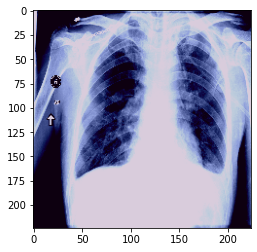

In [ ]:
# for label = 0 
n = index_0[1]
image = test_img[n]
fig, ax = plt.subplots()
plt.imshow(image)
plt.imshow(test_masks[n], alpha=0.2)

label_img = label(test_masks[n])
regions = regionprops(label_img)

MIN_AREA=100
boxes = []

for props in regions:    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2.5)
    
    if props.area > MIN_AREA:
        x = props.bbox[1]
        y = props.bbox[2]
        w = props.bbox[1]+props.bbox[3]
        h = props.bbox[0]+props.bbox[2]
        boxes.append([x,y,w,h]) 
plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


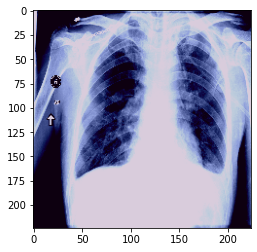

In [ ]:
fig, ax = plt.subplots()
#pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))
pred_mask = model.predict(test_img[n].reshape(1,224,224,3))
pred_mask = pred_mask.reshape(224,224)
pred_mask_t = pred_mask>0.95
plt.imshow(image)
plt.imshow(pred_mask_t,alpha=0.2)

label_img = label(pred_mask_t)
regions = regionprops(label_img)

MIN_AREA=100
boxes = []

for props in regions:    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2.5)
    
    if props.area > MIN_AREA:
        x = props.bbox[1]
        y = props.bbox[2]
        w = props.bbox[1]+props.bbox[3]
        h = props.bbox[0]+props.bbox[2]
        boxes.append([x,y,w,h])  

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


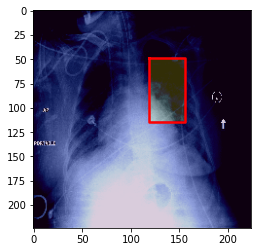

In [ ]:
n = index_1[1]
image = test_img[n]
fig, ax = plt.subplots()
plt.imshow(image)
plt.imshow(test_masks[n], alpha=0.2)

label_img = label(test_masks[n])
regions = regionprops(label_img)

MIN_AREA=100
boxes = []

for props in regions:    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2.5)
    
    if props.area > MIN_AREA:
        x = props.bbox[1]
        y = props.bbox[2]
        w = props.bbox[1]+props.bbox[3]
        h = props.bbox[0]+props.bbox[2]
        boxes.append([x,y,w,h]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


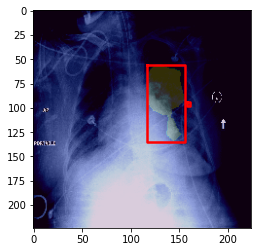

In [ ]:

fig, ax = plt.subplots()
#pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.985), (IMAGE_WIDTH,IMAGE_HEIGHT))
pred_mask = model.predict(test_img[n].reshape(1,224,224,3))
pred_mask = pred_mask.reshape(224,224)
pred_mask_t = pred_mask>0.95
plt.imshow(image)
plt.imshow(pred_mask_t,alpha=0.2)

label_img = label(pred_mask_t)
regions = regionprops(label_img)

MIN_AREA=100
boxes = []

for props in regions:    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-r', linewidth=2.5)
    
    if props.area > MIN_AREA:
        x = props.bbox[1]
        y = props.bbox[2]
        w = props.bbox[1]+props.bbox[3]
        h = props.bbox[0]+props.bbox[2]
        boxes.append([x,y,w,h])  

plt.show()